In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

2024-08-06 12:23:15.008606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 12:23:15.039291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [5]:
pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

In [6]:
# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)


In [7]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240805/'

In [8]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

In [9]:
pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

In [10]:
pc1_u

17072.171156340482

In [11]:
# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

In [12]:
# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

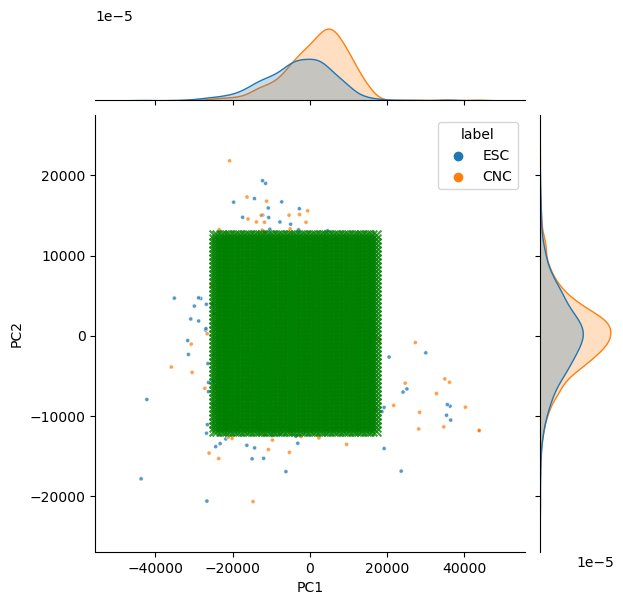

In [13]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.scatter(pc1_grid_flat, pc2_grid_flat, marker='x', color='green', s=50, alpha=0.75)
# plt.savefig(save_dir + 'pca_2d_with_metastructure.png', dpi=300, bbox_inches='tight')

In [26]:
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

In [27]:
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

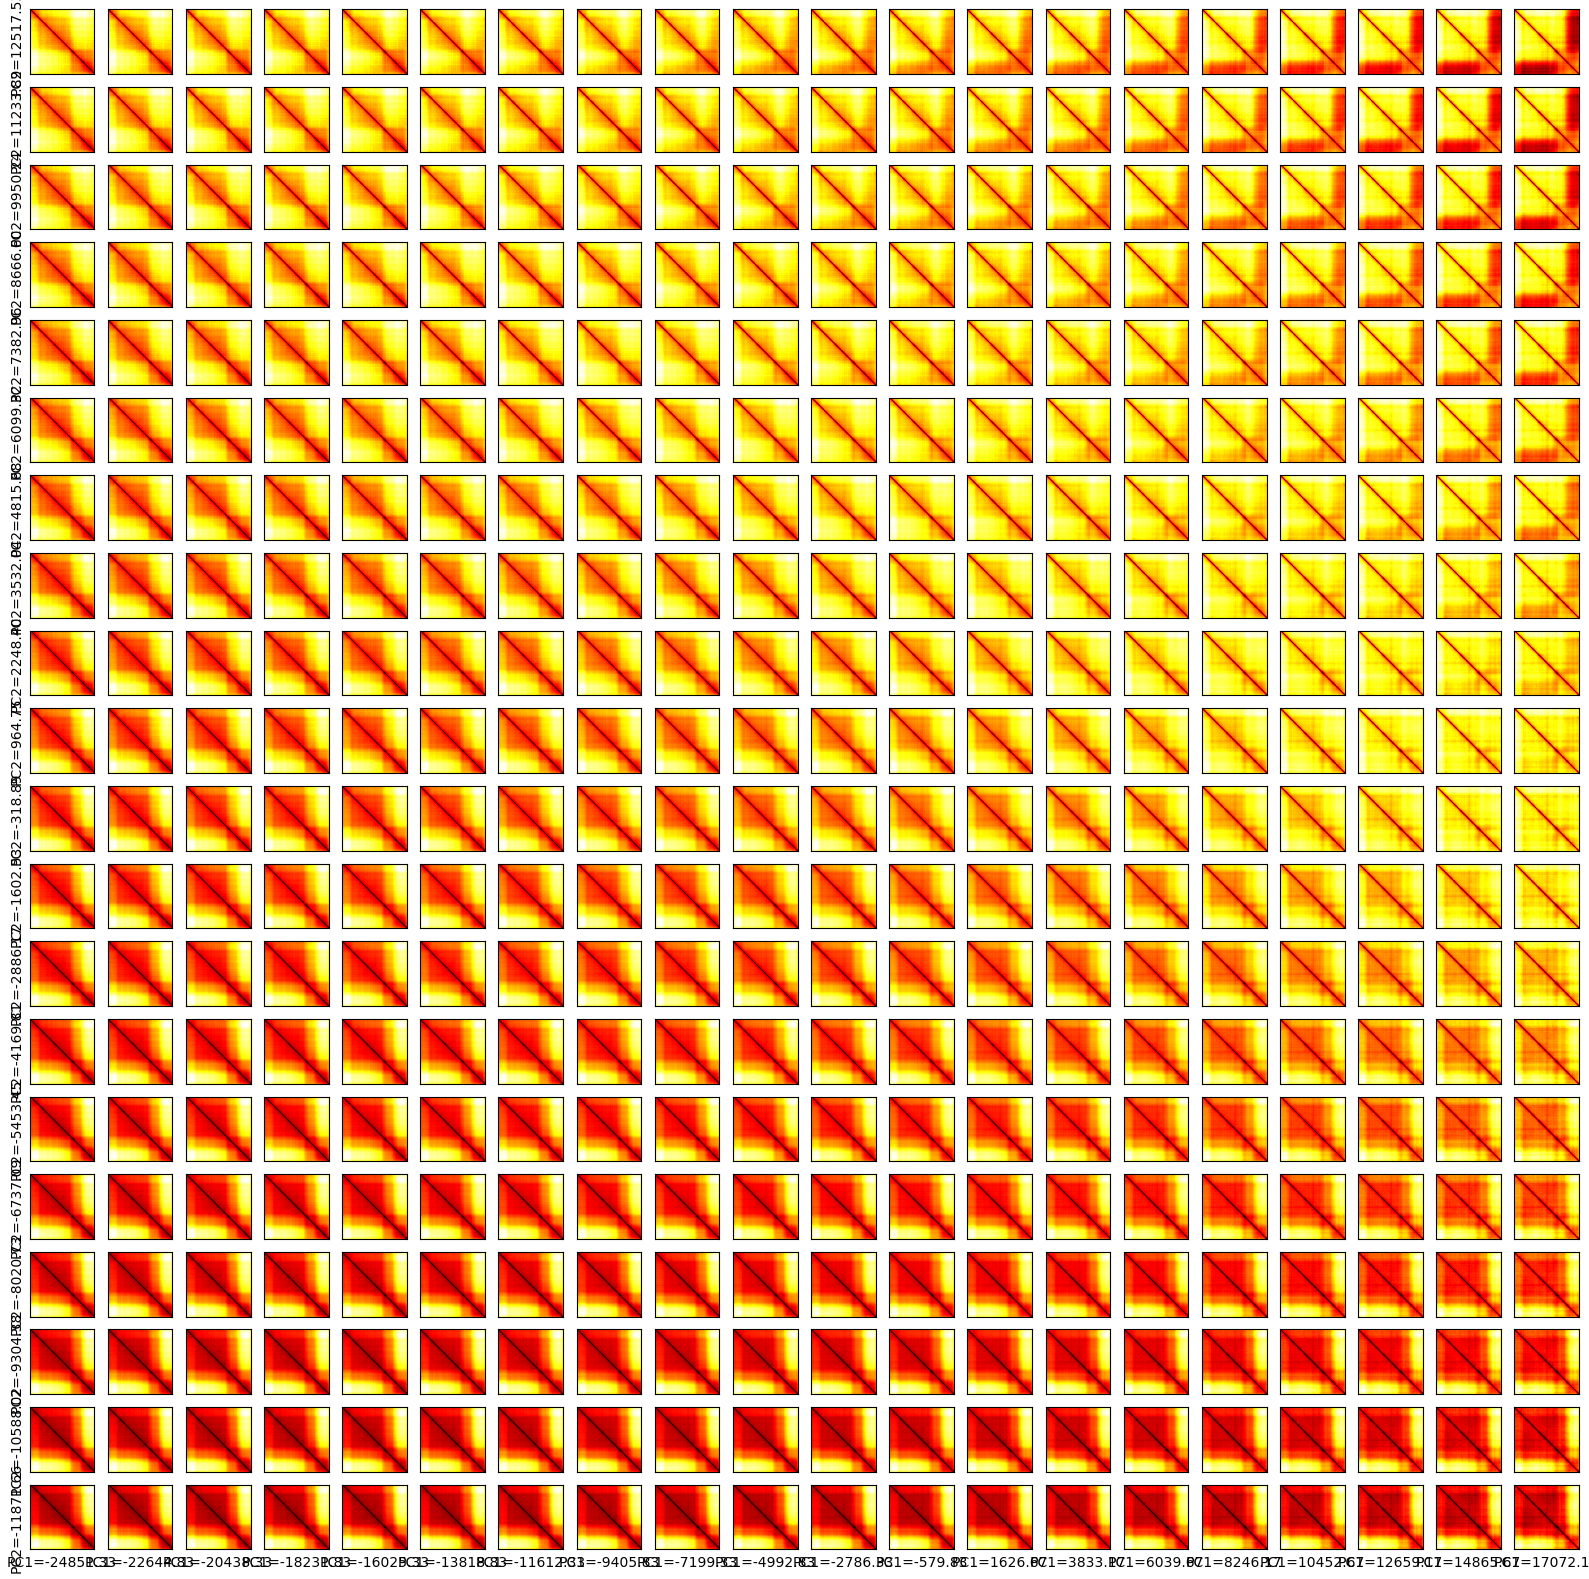

In [28]:
# Plot 10 x 10 grid of metastructures based on PC1 and PC2 
fig, axs = plt.subplots(20, 20, figsize=(20, 20))
for i in range(400):
    ax = ax=axs[i%20, i//20]
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='hot')
    # ax.set_title(f'M{i}')
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    if i // 20 == 0:
        ax.set_ylabel(f'PC2={pc1_pc2_df.iloc[i, 1]:.2f}')
    # if ax is in the last row, add a x label
    if i % 20 == 19:
        ax.set_xlabel(f'PC1={pc1_pc2_df.iloc[i, 0]:.2f}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
# plt.savefig(save_dir + 'metastructure_maps_sorted_by_pca.png', dpi=300, bbox_inches='tight')

In [29]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [61]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240805_WeightMCMC_PCA_metastructures_3/'

In [65]:
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')


In [66]:
esc_log_weights = load_weights(stan_directory_esc, 2500)
cnc_log_weights = load_weights(stan_directory_cnc, 2500)
# all_log_weights = load_weights(stan_directory_all, 2500)

['20240715_WeightOptimization-20240805173511_1.csv', '20240715_WeightOptimization-20240805173511_2.csv', '20240715_WeightOptimization-20240805173511_3.csv', '20240715_WeightOptimization-20240805173511_4.csv']
['20240715_WeightOptimization-20240805174107_1.csv', '20240715_WeightOptimization-20240805174107_2.csv', '20240715_WeightOptimization-20240805174107_3.csv', '20240715_WeightOptimization-20240805174107_4.csv']


In [67]:
esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

In [70]:
cnc_weights.shape

(2500,)

In [74]:
# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [35]:
import matplotlib

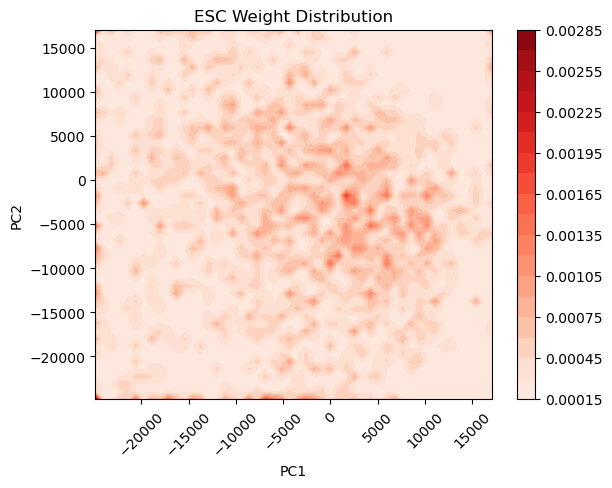

In [83]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.003)
plt.contourf(esc_weights_df['PC1'].unique(), esc_weights_df['PC2'].unique(), 
             esc_weights_df['weight'].values.reshape(50, 50).T,
             norm=norm, levels=20, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC Weight Distribution')
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, 'esc_weight_distribution_large.png'), dpi=300, bbox_inches='tight')

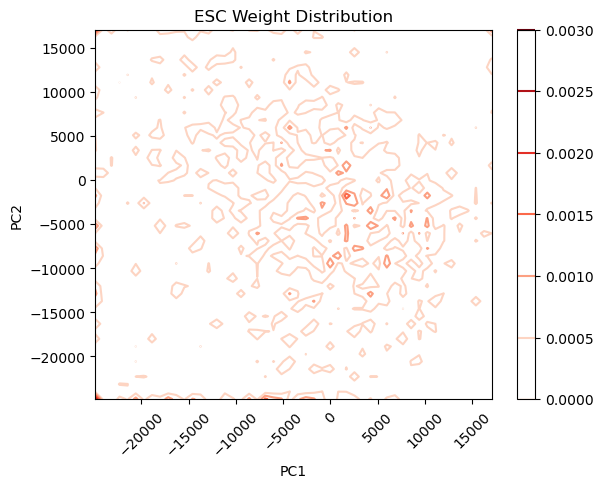

In [88]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.003)
plt.contour(esc_weights_df['PC1'].unique(), esc_weights_df['PC2'].unique(), 
             esc_weights_df['weight'].values.reshape(50, 50).T,
             norm=norm, levels=5, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC Weight Distribution')
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, 'esc_weight_distribution_large_contour.png'), dpi=300, bbox_inches='tight')

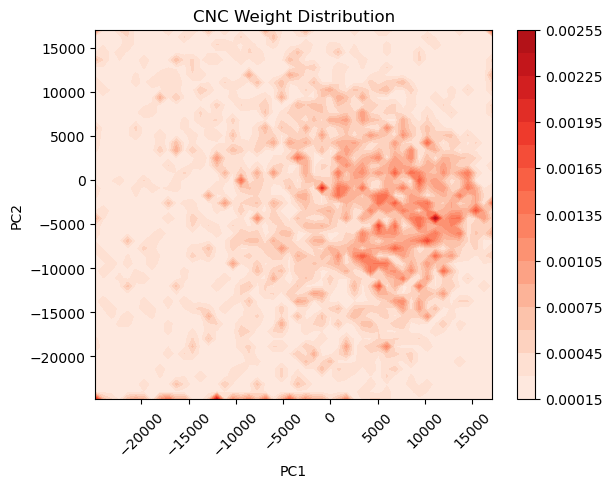

In [84]:
plt.contourf(cnc_weights_df['PC1'].unique(), cnc_weights_df['PC2'].unique(), 
             cnc_weights_df['weight'].values.reshape(50, 50).T,
             norm=norm, levels=20, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC Weight Distribution')
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, 'cnc_weight_distribution_large.png'), dpi=300, bbox_inches='tight')

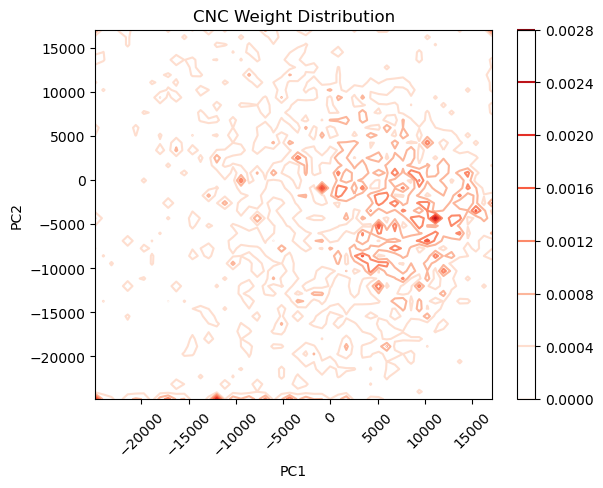

In [89]:
plt.contour(cnc_weights_df['PC1'].unique(), cnc_weights_df['PC2'].unique(), 
             cnc_weights_df['weight'].values.reshape(50, 50).T,
             norm=norm, levels=5, cmap='Reds')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC Weight Distribution')
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, 'cnc_weight_distribution_large_contour.png'), dpi=300, bbox_inches='tight')

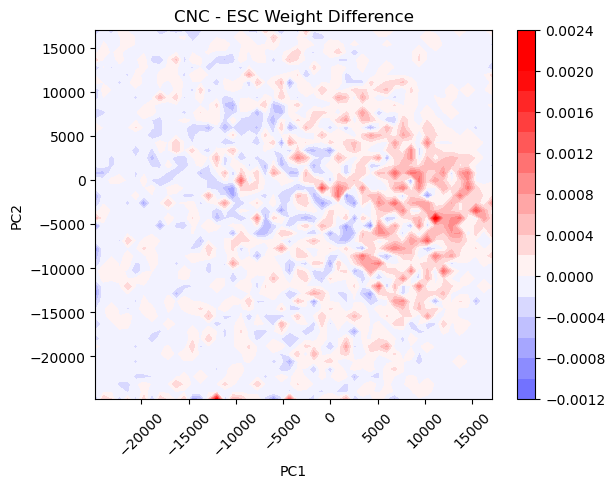

In [82]:
weight_diff = cnc_weights_df['weight'].values.reshape(50, 50).T - esc_weights_df['weight'].values.reshape(50, 50).T
plt.contourf(cnc_weights_df['PC1'].unique(), cnc_weights_df['PC2'].unique(),
                weight_diff, levels=20, cmap='bwr', vmin=-0.002, vmax=0.002)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC - ESC Weight Difference')
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, 'cnc_esc_weight_difference_large.png'), dpi=300, bbox_inches='tight')

In [50]:
import matplotlib.animation as animation

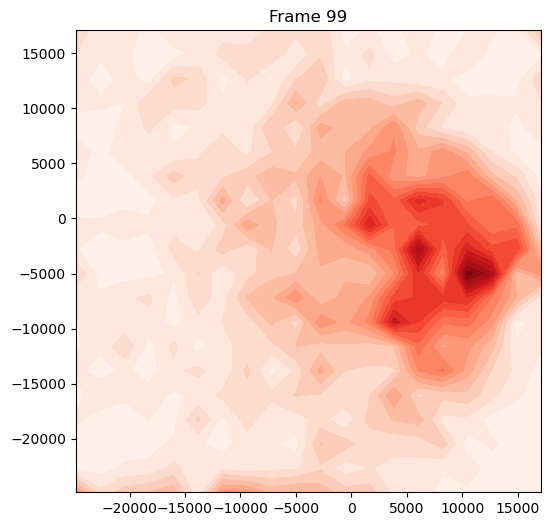

In [60]:
Z_esc = esc_weights_df['weight'].values.reshape(20, 20).T
Z_cnc = cnc_weights_df['weight'].values.reshape(20, 20).T

# Define number of frames for the animation
frames = 100

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
X = esc_weights_df['PC1'].unique()
Y = esc_weights_df['PC2'].unique()

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.01)
contour = ax.contourf(X, Y, 
             Z_esc,
             norm=norm, levels=20, cmap='Reds')
# cbar = fig.colorbar(contour, ax=ax)
# cbar.set_label('Weight')

# Function to update the plot
def update(frame):
    ax.clear()  # Clear the previous contour plot
    # Interpolate between Z1 and Z2
    Z = (1 - frame / frames) * Z_esc + (frame / frames) * Z_cnc
    contour = ax.contourf(X, Y, Z, cmap='Reds', levels=20)
    ax.set_title(f'Frame {frame}')
    
    return contour.collections

# Create animation
ani = animation.FuncAnimation(fig, update, frames=frames, blit=False, interval=50)

# Save the animation as a GIF
ani.save(os.path.join(save_dir, 'contour_animation.gif'), writer='pillow', fps=10, dpi=150)
plt.show()

In [2]:
import numpy as np
np.logspace(-3, 5, 9)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05])

In [3]:
str(np.logspace(-3, 5, 9)[0])

'0.001'